This is the first "Lab" cycle. We will create a Notebook to inspect our raw materials before feeding them into the "Factory" (the pipeline).

Our goal in this EDA is **not just visualization**, but **Audit**:

1. **LLM Viability:** Do we have enough text in `description` for embeddings?
2. **Collaborative Feasibility:** Is the `ratings_count` distribution healthy, or extremely skewed?
3. **Bias Check:** Are the top categories diverse enough?

#### **Imports & Configuration**
We set up the environment and define paths dynamically so this notebook runs on any machine.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Identify project root (2 levels up from notebook/)
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_PATH = PROJECT_ROOT / "data" / "raw" / "books.csv"

# Visual settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#### **Load Data (Mocking the Ingestion)**
Note: Since we haven't built the ingestion pipeline yet, download the `7k-books-with-metadata` CSV manually from Kaggle and place it in `data/raw/books.csv`.

In [28]:
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Successfully loaded {df.shape[0]} books and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"❌ Error: File not found at {DATA_PATH.relative_to(PROJECT_ROOT)}. Please download 'books.csv' to 'data/raw/'.")

df.head()

Successfully loaded 6810 books and 12 columns.


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [29]:
print("DataFrame Info:")
df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [30]:
# Duplicated values
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df[df.duplicated()]

Number of duplicate rows: 0


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count


#### **Audit 1 - LLM Feasibility (Text Quality)**
The "Content-Based" track relies entirely on the `description` column. If it's empty or too short, the LLM fails.

Missing Descriptions: 262 (3.8%)


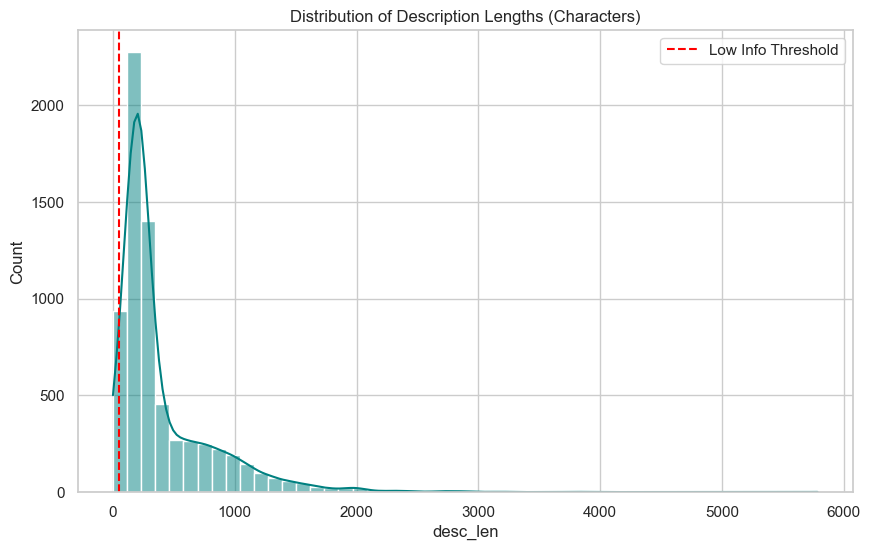

In [7]:
# Check for missing descriptions
missing_desc = df['description'].isnull().sum()
print(f"Missing Descriptions: {missing_desc} ({missing_desc/len(df):.1%})")

# Calculate character counts
df['desc_len'] = df['description'].fillna("").apply(len)

# Plot distribution
sns.histplot(df['desc_len'], bins=50, kde=True, color='teal')
plt.title("Distribution of Description Lengths (Characters)")
plt.axvline(x=50, color='red', linestyle='--', label="Low Info Threshold")
plt.legend()
plt.show()

# Insight:
# If many books are left of the red line, our Semantic Search will be weak for those items.

#### **Audit 2 - Collaborative Feasibility (Sparsity)**
We need to know if we can trust the `average_rating` and `ratings_count`.

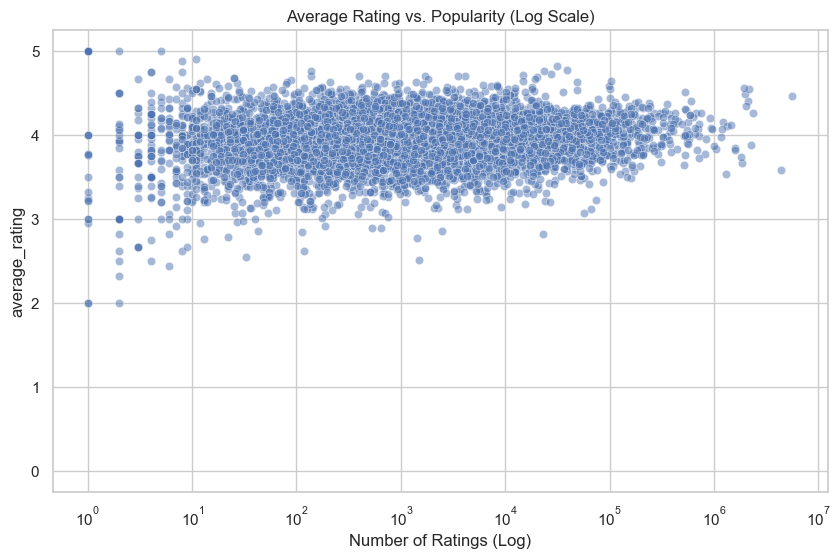

Books with < 10 ratings: 266 (3.9%)


In [8]:
# Plot Rating vs Popularity
sns.scatterplot(data=df, x='ratings_count', y='average_rating', alpha=0.5)
plt.xscale('log')  # Log scale because popularity usually follows Power Law
plt.title("Average Rating vs. Popularity (Log Scale)")
plt.xlabel("Number of Ratings (Log)")
plt.show()

# Quantify the "Long Tail"
low_interaction = df[df['ratings_count'] < 10].shape[0]
print(f"Books with < 10 ratings: {low_interaction} ({low_interaction/len(df):.1%})")

# Insight:
# If this number is high, Traditional ML (Collaborative Filtering) will fail for these books.
# This PROVES the need for our Hybrid approach (LLM covers the low-interaction items).

#### **Audit 3 - Fairness & Bias (Category Distribution)**
Are we only recommending "Fiction"?

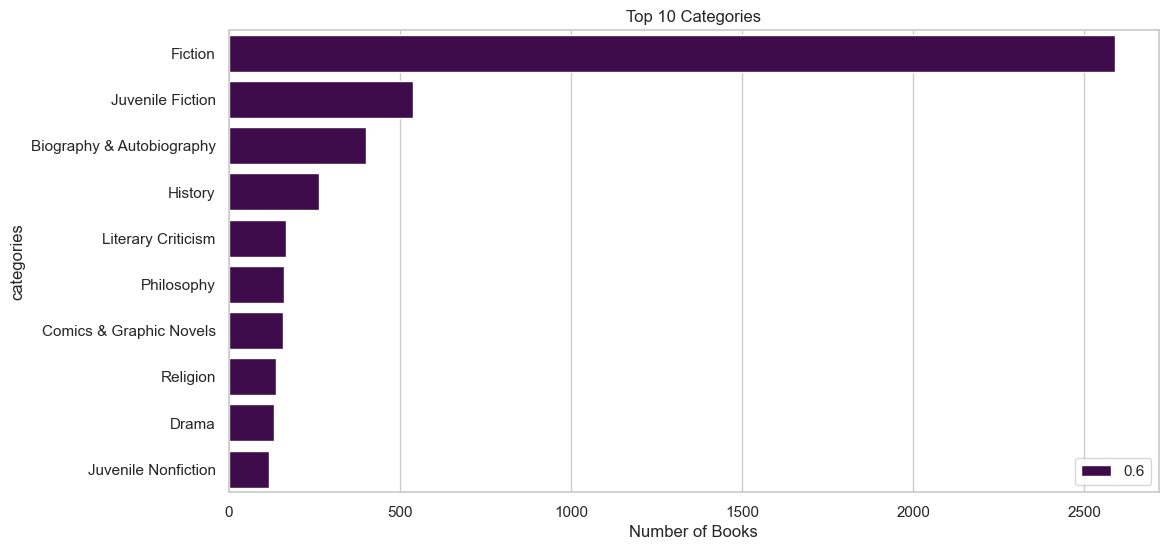

In [12]:
# Check top categories
top_categories = df['categories'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis", hue=0.6)
plt.title("Top 10 Categories")
plt.xlabel("Number of Books")
plt.show()

# Fairness Check:
# If 'Fiction' is 90% of the data, our model is biased toward Fiction.
# We might need to stratify our sampling or use the LLM to 'discover' sub-genres.

#### **Missingness Analysis**

In [31]:
print(df.isnull().sum())

isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
dtype: int64


**NOTE**: Observations that have either `average_rating`, `num_pages`, or `ratings_count` missing have all of them missing. These are probably books that are not available in the dataset, or are not available in English. This may be a source of bias, because the books that are not available is becuase they have a low rating, or they are new books.

**Is there any bias in the type of description we have missing?** 

We need to know if our recommender system is going to skew toward certain genres or authors.

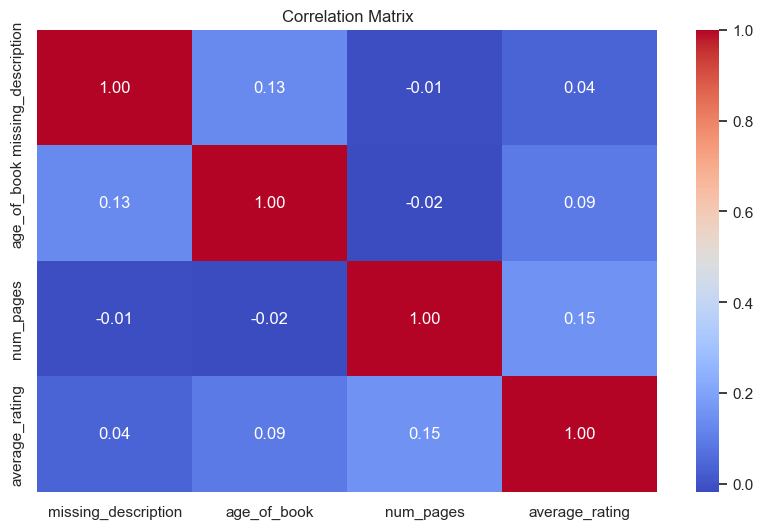

In [ ]:
# Check weather the missing descriptions are more likely to be shorter or older
df["missing_description"] = np.where(df["description"].isnull(), 1, 0)
df["age_of_book"] = 2024 - df["published_year"]

important_columns = ["missing_description", "age_of_book", "num_pages", "average_rating"]
correlation_matrix = df[important_columns].corr(method="spearman")  # More appropriate for ordinal data

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [26]:
percent_missing = df[["description", "num_pages", "average_rating", "published_year"]].isna().any(axis=1).mean() * 100
print(f"Percentage of rows with missing values: {percent_missing:.2f}%")

Percentage of rows with missing values: 4.45%


> Not really a strong relationship with missing description. Give we have a small number of missing values and it doesn't seem to be a pattern in term of missingness, we can safely drop them for simplicity.

In [33]:
books_clean = df[~(df["description"].isna()) &
      ~(df["num_pages"].isna()) &
      ~(df["average_rating"].isna()) &
      ~(df["published_year"].isna())
]

**Are descriptions actually meaningful?**

In [41]:
books_clean["description"].head(10)

0    A NOVEL THAT READERS and critics have been eag...
1    A new 'Christie for Christmas' -- a full-lengt...
2    Volume Two of Stephen Donaldson's acclaimed se...
3    A memorable, mesmerizing heroine Jennifer -- b...
4    Lewis' work on the nature of love divides love...
5    "In The Problem of Pain, C.S. Lewis, one of th...
6                                            Donation.
7    Until Vasco da Gama discovered the sea-route t...
8    A new-cover reissue of the fourth book in the ...
9    Kate Blackwell is an enigma and one of the mos...
Name: description, dtype: object

C:\Users\sebas\AppData\Local\Temp\ipykernel_16044\2478491105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_clean["words_in_description"] = books_clean["description"].str.split().str.len()


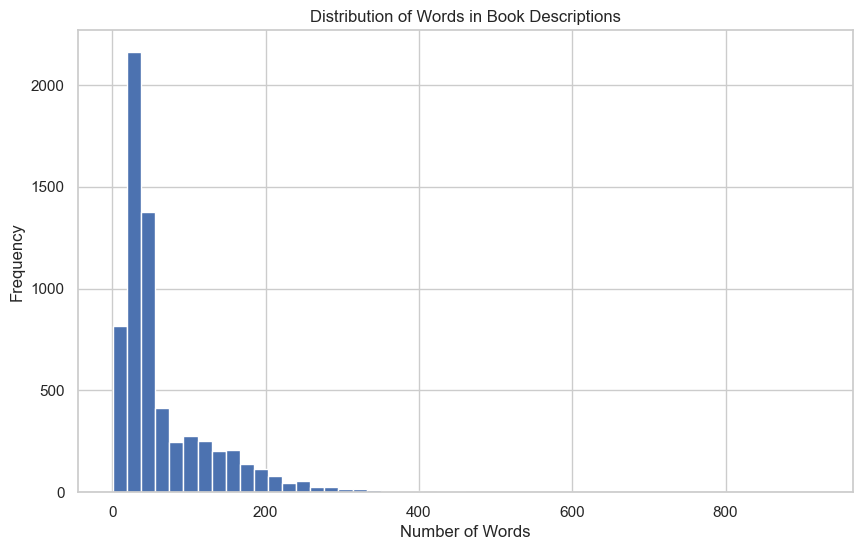

In [44]:
books_clean["words_in_description"] = books_clean["description"].str.split().str.len()
books_clean["words_in_description"].plot(kind="hist", bins=50, figsize=(10, 6))
plt.title("Distribution of Words in Book Descriptions")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [50]:
books_clean.loc[books_clean["words_in_description"].between(1, 3), "description"].head(30)

6                                  Donation.
11                            Fantasy-roman.
748     Includes bibliographical references.
775                       No Marketing Blurb
812                       No Marketing Blurb
953               DEFOE/ROBINSON CRUSOE (BC)
962                ALLEN/GETTING THINGS DONE
1054                   GILBERT/EAT PRAY LOVE
1346                          Fantasy-roman.
1546                             Winter 2003
1610                             Winter 1999
1813                    National bestseller.
1981                                Romance.
2089                      Oprah's Book Club.
2946                  FICTION-ROMANCE/GOTHIC
3064                      No Marketing Blurb
3364                          Fantasy-roman.
3435                        Science fiction.
3611                       Cast ages: adult.
3645                  Science fiction-roman.
3959                          Ketubot Part I
4262                    Issued in container.
4898      

In [51]:
books_clean.loc[books_clean["words_in_description"].between(3, 15), "description"].head(30)

2      Volume Two of Stephen Donaldson's acclaimed se...
38     Koko is Peter Straub's foray into the psycholo...
70     A matter of life and death - and the Throne of...
77                        Nonsense rhyming story. 4 yrs+
83     Tie your tongue in terrible knots as you try t...
84     A study guide for the novel There's a Boy in t...
90     An epic narrative that takes a look at slavery...
94     The title story in this collection of shorts n...
100    Forty-nine stories reflect much of the intensi...
104                       Library of Liberal Arts title.
111    Rabbit's schedule keeps him so busy his friend...
133    Provides daily reminders of the differences in...
154    A collection of humorous poems and drawings. C...
241    Originally published: [New York]: Clarion Book...
259    Presents three stories of teenagers beset by h...
333    A stunning collection of Annie Dillard's most ...
357    The most eloquent translation of Homer's Odyss...
363    A New York City chef and

> Short comments does not communicate a valuable desription for our recommendation system.

In [52]:
book_with_20_words = books_clean[books_clean["words_in_description"] >= 20]

In [53]:
percentage_20_words = (len(book_with_20_words) / len(books_clean)) * 100
print(f"Percentage of books with at least 20 words: {percentage_20_words:.2f}%")

Percentage of books with at least 20 words: 87.49%


`subtitle` column is unusable on its own because it contains so many missing values, but it's common to have a book pair with title and subtitle.

In [55]:
book_with_20_words["title_and_subtitle"] = (
    np.where(book_with_20_words["subtitle"].isna(), book_with_20_words["title"],
             book_with_20_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)

C:\Users\sebas\AppData\Local\Temp\ipykernel_16044\3277459481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_with_20_words["title_and_subtitle"] = (


In [57]:
book_with_20_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,20.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,24.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,31.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,22.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,22.0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,22.0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,21.0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,25.0,174,I Am that: Talks with Sri Nisargadatta Maharaj
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,43.0,245,The Berlin Phenomenology


In [58]:
book_with_20_words.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5693 entries, 0 to 6809
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn13                5693 non-null   int64  
 1   isbn10                5693 non-null   object 
 2   title                 5693 non-null   object 
 3   subtitle              2010 non-null   object 
 4   authors               5646 non-null   object 
 5   categories            5662 non-null   object 
 6   thumbnail             5506 non-null   object 
 7   description           5693 non-null   object 
 8   published_year        5693 non-null   float64
 9   average_rating        5693 non-null   float64
 10  num_pages             5693 non-null   float64
 11  ratings_count         5693 non-null   float64
 12  missing_description   5693 non-null   int64  
 13  age_of_book           5693 non-null   float64
 14  words_in_description  5693 non-null   int64  
 15  title_and_subtitle    5693

**Save the cleaned dataset to a CSV file**

In [ ]:
# (
#     book_with_20_words
#     .drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1)
#     .to_csv("../data/interim/books_cleaned.csv", index = False)
# )